# Langgraph notebook 2
https://langchain-ai.github.io/langgraph/

Building agents from graphs

From tutorial: https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

In [10]:
# The basics

from dotenv import load_dotenv
import os
import json
import re
from openai import OpenAI

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Gather information

In [1]:
from typing import List, Dict, Any
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [82]:
template = """Your job is to gather information from a user about the Opentrons liquid handling task or workflow they want to perform. Assume all information provided by the user is correct and do not ask for confirmation of details already given. Focus on collecting only the information necessary to complete the specific request.

Here is the default deck state:
{default_deck_state}

Assume the information in the default deck state is correct unless something in the user input suggests a conflict with the default deck state, in which case clarify.

You should get the following information from the default deck state and user input:

- A detailed description of the workflow, including all steps to be performed. If the user provides a single discrete command, assume this constitutes the entire workflow.
- Information about the deck setup, but only as it relates to the specific task:
  - Attached pipettes (only if liquid handling is involved)
  - Labware on the deck (only the relevant containers for the task)
  - Tip racks (only if pipetting is required)
  - Any modules (e.g., thermocycler, magnetic module) that are specifically needed

For each step in the workflow, gather relevant details such as:
- The specific operation (e.g., transfer, mix, dispense, thermocycler operation)
- Volumes of liquid involved (if applicable)
- Source and destination containers (if applicable)
- Specific wells or locations within containers (if specified)
- Pipette to be used (if applicable)
- Any other relevant parameters for the operation

Provide deck state information only for the components directly involved in the task. Use empty dictionaries for categories that are not relevant to the specific request.

If any crucial information is missing or unclear, ask the user to clarify, but do not ask for confirmation of information already provided. Do not guess or assume any details not explicitly stated. Safety and accuracy are paramount in lab operations.

IMPORTANT:
- Pay close attention to specific volumes mentioned by the user. Do not change or assume different volumes.
- Only include steps that are explicitly requested by the user. Do not add extra steps unless specifically mentioned.
- When transferring liquids, use the exact wells specified by the user. Do not assume transfers between multiple wells unless stated.
- Do not associate specific labware with pipettes unless explicitly stated by the user or in the default deck state.

Examples:
1. If the user request is "Set the temperature of the thermocycler in slot 7 to 37°C":
   - You only need to know the location of the thermocycler module (which is given).
   - You don't need information about pipettes, labware, or tip racks.
   - Do not add any steps to run a thermocycler profile unless explicitly requested.

2. If the user request is "Transfer 20 µL from well A1 of a 96-well plate in slot 1 to well A1 of the plate on the thermocycler using the left pipette":
   - You know:
     - The location of both 96-well plates
     - The specific wells for transfer (A1 to A1)
     - The exact volume to transfer (20 µL)
     - The pipette to be used (left)
   - You still need to know:
     - The location of the appropriate tip rack
   - Do not assume transfers between multiple wells or change the specified volume.

After you have gathered all necessary information, organize it into a list of workflow steps, the relevant deck state, and any module states, then call the relevant tool."""

class OpentronsDeckState(BaseModel):
    """Information about the current state of the Opentrons deck."""
    pipettes: Dict[str, str] = Field(default_factory=dict, description="Pipettes attached to the robot, e.g., {'left': 'p300_single', 'right': 'p1000_multi'}")
    labware: Dict[str, str] = Field(default_factory=dict, description="Labware on the deck, e.g., {'1': 'opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap'}")
    tip_racks: Dict[str, str] = Field(default_factory=dict, description="Tip racks on the deck, e.g., {'2': 'opentrons_96_tiprack_300ul'}")
    modules: Dict[str, str] = Field(default_factory=dict, description="Modules attached to the deck, e.g., {'7': 'thermocycler'}")


class OpentronsInstructions(BaseModel):
    """Flexible instructions for Opentrons liquid handling tasks."""
    workflow: List[Dict[str, Any]]  # A list of steps in the workflow
    deck_state: OpentronsDeckState

def read_default_deck_state(file_path: str):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Warning: Default deck state file not found at {file_path}. Using empty state.")
        return {}
    except json.JSONDecodeError:
        print(f"Warning: Invalid JSON in deck state file at {file_path}. Using empty state.")
        return {}

def get_messages_info(messages):
    default_deck_state = read_default_deck_state("deck_state.json")
    formatted_deck_state = json.dumps(default_deck_state, indent=2)
    return [SystemMessage(content=template.format(default_deck_state=formatted_deck_state))] + messages

llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tool = llm.bind_tools([OpentronsInstructions])

chain = get_messages_info | llm_with_tool

In [83]:
read_default_deck_state("deck_state.json")

{'robot_type': 'OT-2',
 'api_version': '2.17',
 'pipettes': {'left': {'type': 'p300_single_gen2'},
  'right': {'type': 'p20_multi_gen2'}},
 'modules': {'thermocycler': {'type': 'thermocyclerModuleV2',
   'location': ['7']}}}

## Generate code

In [84]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# New system prompt for code generation
code_gen_system = """Based on the following Opentrons workflow and deck state, generate Python code using the Opentrons API:

{instructions}

Ensure the code follows best practices for the Opentrons API, includes proper error handling, and is well-commented for clarity.

Output just the commented code without any explanations or additional text. The user should be able to copy and paste the code into their Python script and run it without any modifications.
"""

# Function to get the messages for code generation
# Will only get messages AFTER the tool call
def get_code_gen_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=code_gen_system.format(instructions=tool_call))] + other_msgs

code_gen_chain = get_code_gen_messages | llm

## Define the state logic

In [85]:
from typing import Literal
from langgraph.graph import END

def get_state(messages) -> Literal["add_tool_message", "info", "__end__"]:
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

## Create the graph

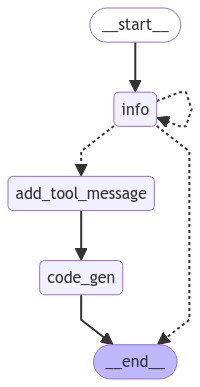

In [86]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, MessageGraph
from langchain_core.messages import ToolMessage

memory = SqliteSaver.from_conn_string(":memory:")
workflow = MessageGraph()

# Add nodes
workflow.add_node("info", chain)
workflow.add_node("code_gen", code_gen_chain)

@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Opentrons instructions received. Generating code...",
        tool_call_id=state[-1].tool_calls[0]["id"]
    )

# Add edges
workflow.add_conditional_edges("info", get_state)
workflow.add_edge("add_tool_message", "code_gen")
workflow.add_edge("code_gen", END)
workflow.add_edge(START, "info")

# Compile the graph
graph = workflow.compile(checkpointer=memory)

# Visualization (if in a Jupyter environment)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Use the graph

In [87]:
import uuid

# Read the default deck state
default_deck_state = read_default_deck_state("deck_state.json")

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    
    print(f"\n================================== Human Input ==================================\n{user}\n")
    
    output = None
    for output in graph.stream(
        [HumanMessage(content=user)], 
        config=config, 
        stream_mode="updates"
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "code_gen" in output:
        print("Done!")


================================== Human Input ==================================
Please set the temperature of the thermocycler in deck slot 7 to 90 degC. After it has reached that temp, please transfer 20 uL from well 1A of a 96 well plate in slot 1 to the plate on the thermocycler (same well). Blow out tip and then discard the tip.

================================== Ai Message ==================================

To complete your request, I will perform the following steps:

1. Set the temperature of the thermocycler in slot 7 to 90°C.
2. After the thermocycler reaches 90°C, transfer 20 µL from well A1 of a 96-well plate in slot 1 to well A1 of the plate on the thermocycler.
3. Blow out the tip and discard it.

Here is the relevant deck state information for the task:

- **Deck State:**
  - **Pipettes:**
    - Left: p300_single_gen2
    - Right: p20_multi_gen2
  - **Labware:**
    - 96-well plate in slot 1
    - 96-well plate on the thermocycler in slot 7
  - **Tip Racks:**
    - (